In [ ]:
import torch
import numpy as np
import torch.nn  as nn
import gymnasium as gym
import random
import math
from collections import deque
import copy
from IPython import display
import imageio
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
env = gym.make('LunarLander-v2')

class LunarLanderModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LunarLanderModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            # nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

model = LunarLanderModel(input_dim, output_dim).to(device)
model.eval()
obs = torch.Tensor(env.reset()[0]).view(1, -1).to(device)
model(obs).shape

In [ ]:
input_dim, output_dim

In [ ]:
class UniformReplayMemory():
    def __init__(self, memory_size: int):
        self.memories = deque([], memory_size)

    def append(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.memories.append(
            {
                "obs": torch.tensor(obs, dtype=torch.float).to(device),
                "action": torch.tensor(action, dtype=torch.long).to(device),
                "reward": torch.tensor(reward, dtype=torch.float).to(device),
                "next_obs": torch.tensor(next_obs, dtype=torch.float).to(device),
                "done": torch.tensor(done, dtype=torch.long).to(device),
            }
        )

    def sample(self, k) -> dict:
        return random.sample(self.memories, k)

    def __len__(self) -> int:
        return len(self.memories)
    

In [20]:
class DQN:
    def __init__(
        self,
        env: gym.Env,
        model: torch.nn.Module,
        minibatch_size=128,
        target_update_frequency=100,
        use_ddqn_loss=True,
        discount_factor=0.99,
        update_frequency=1,
        learning_rate=1e-4,
        plot_update_frequency=10,
        max_episode_steps=108000,

        initial_exploration=1.0,
        final_exploration=0.05,
        exploration_decay=5000,
    ):
        self.env = env
        self.model = model
        self.minibatch_size = minibatch_size
        self.target_update_frequency = target_update_frequency
        self.use_ddqn_loss = use_ddqn_loss
        self.discount_factor = discount_factor
        self.update_frequency = update_frequency
        self.plot_update_frequency = plot_update_frequency
        self.max_episode_steps = max_episode_steps

        self.starting_epsilon = initial_exploration
        self.ending_epsilon = final_exploration
        self.epsilon_decay = exploration_decay

        self.total_steps = 0
        # self.train_losses = []
        self.episode_rewards = []

        self.replay_memory = UniformReplayMemory(memory_size=50000)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.done = True

        self._update_target_model_weights()

    def is_exploit(self):
        random_action_probability = self.ending_epsilon + (
            self.starting_epsilon - self.ending_epsilon
        ) * math.exp(-1.0 * self.total_steps / self.epsilon_decay)
        return random.uniform(0, 1) >= random_action_probability

    def get_action(self, obs: np.ndarray, force_greedy=False) -> int:
        if force_greedy or self.is_exploit():
        # if force_greedy:
            self.model.eval()
            with torch.no_grad():
                # print(torch.Tensor(obs).shape, self.model(torch.Tensor(obs)))
                q_value_max = self.model(torch.Tensor(obs).view(1, -1).to(device)).argmax(dim=1)
            self.model.train()
            return q_value_max.item()

        return self.env.action_space.sample()
    
    def _step(self, obs: np.ndarray) -> tuple[np.ndarray, bool]:
        action = self.get_action(obs)
        # print(action)
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        # print(done)
        self.replay_memory.append(obs, action, reward, next_obs, done)
        self.total_steps += 1
        return next_obs, done, reward

    def _update_model_weights(self) -> float:
        batch = self.replay_memory.sample(self.minibatch_size)
        batch = {key: torch.stack([b[key] for b in batch]) for key in batch[0].keys()}
        q_value = self.model(batch["obs"]).gather(1, batch["action"].unsqueeze(1)).squeeze(1)
        target_next_q_values = self.target_model(batch["next_obs"])
        dones = batch["done"]

        if self.use_ddqn_loss:
            next_q_values = self.model(batch["next_obs"])
            next_q_value = target_next_q_values.gather(
                1, torch.max(next_q_values, 1)[1].unsqueeze(1)
            ).squeeze(1)
        else:
            next_q_value = target_next_q_values.max(dim=1)[0]
            
        target_q_value = batch["reward"] + self.discount_factor * next_q_value * (
            1 - dones
        )

        loss = torch.nn.functional.smooth_l1_loss(q_value, target_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        return loss.item()

    def _update_target_model_weights(self) -> None:
        self.target_model = copy.deepcopy(self.model).eval()

    def learn(self, num_episodes=500) -> None:
        # should_break = False
        for episode in range(1, num_episodes + 1):
            if self.done:
                self.obs = self.env.reset()[0]
                episode_reward = 0

            for step in range(self.max_episode_steps):
                self.obs, self.done, reward = self._step(self.obs)
                episode_reward += reward
                if (len(self.replay_memory) >= self.minibatch_size and step % self.update_frequency == 0):
                    self._update_model_weights()

                if self.done:
                    break

            self.episode_rewards.append(episode_reward)

            if episode % self.target_update_frequency == 0:
                self._update_target_model_weights()

            if episode % self.plot_update_frequency == 0:
                display.clear_output()
                print(f"Episode: {episode}, Episode Reward: {sum(self.episode_rewards[-self.plot_update_frequency:])/len(self.episode_rewards[-self.plot_update_frequency:])}")
                plt.plot(self.episode_rewards)
                plt.show()


        self.env.close()

env = gym.make('LunarLander-v2')
dqn = DQN(env=env, model=model)
# dqn.get_action(obs.numpy())
# dqn._step(obs.numpy())
# dqn.learn(num_episodes=300)
# dqn._update_model_weights()

Episode: 10, Episode Reward: -153.16916154841854


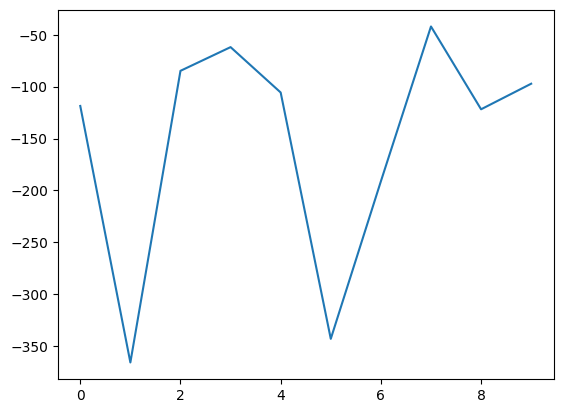

In [21]:
model = model.to(device)
dqn.learn(num_episodes=100)
torch.save(model.state_dict(), 'model_state_3.pth')

In [16]:
env = gym.make('LunarLander-v2', render_mode="human")
model = model.cpu().eval()
# model.load_state_dict(torch.load('model_state.pth'))
obs = env.reset()[0]
done = False

episode_reward = 0
while not done:
    action = model(torch.Tensor(obs).view(1, -1)).max(1)[1].item()
    obs, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    done = terminated or truncated
    env.render()
    if done:
        env.close()

print(episode_reward)

-102.6871822385802
